# Carga de datos de entrenamiento y librerias

In [33]:
# Importaciones de TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Activation,LSTM
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.regularizers import  l2
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Importaciones de Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Importaciones de Transformers
from transformers import BertTokenizer, TFBertForTokenClassification, pipeline, TrainingArguments, Trainer,BertTokenizerFast

# Importaciones de otras bibliotecas y módulos
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import spacy
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy.special import softmax

from seqeval.metrics import classification_report

In [4]:
nlp=spacy.load('en_core_web_md')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data=pd.read_pickle('../Data/train_data.pickle')

# Análisis exploratorio

## Tratamiento de nulos

In [ ]:
data.isnull().sum()

label_NER            0
text                 0
adults            5307
children         90706
days             43809
month            31740
special_date    168779
dtype: int64

In [ ]:
data=data.fillna(0)

## Análisis de texto

In [ ]:
data.text.sample(10).values

array(['Is there a room available for 7 adults and 8 teenagers during New Year?',
       'Is there availability for 3 adults for 30 days in July?',
       'I need a room for 6 adults and 8 kids for 9 days in December.',
       'I am looking to book a room for 2 adults for 29 days.,I want to reserve a room for 29 days in March for 2 adults.',
       'I need room availability for 11 adults and 4 children in June.',
       'Looking for availability for 5 adults and 8 children in January.',
       'Looking for room availability for 5 adults for 30 days in October.',
       'Is there availability for 11 adults for 8 days in September?',
       'I am looking for a room for 11 adults and 4 children for 22 days in June.',
       'Could I reserve a room for 12 adults and 9 children for 20 days in October?'],
      dtype=object)

In [ ]:
data['pre_clean_len'] = data.text.str.len()

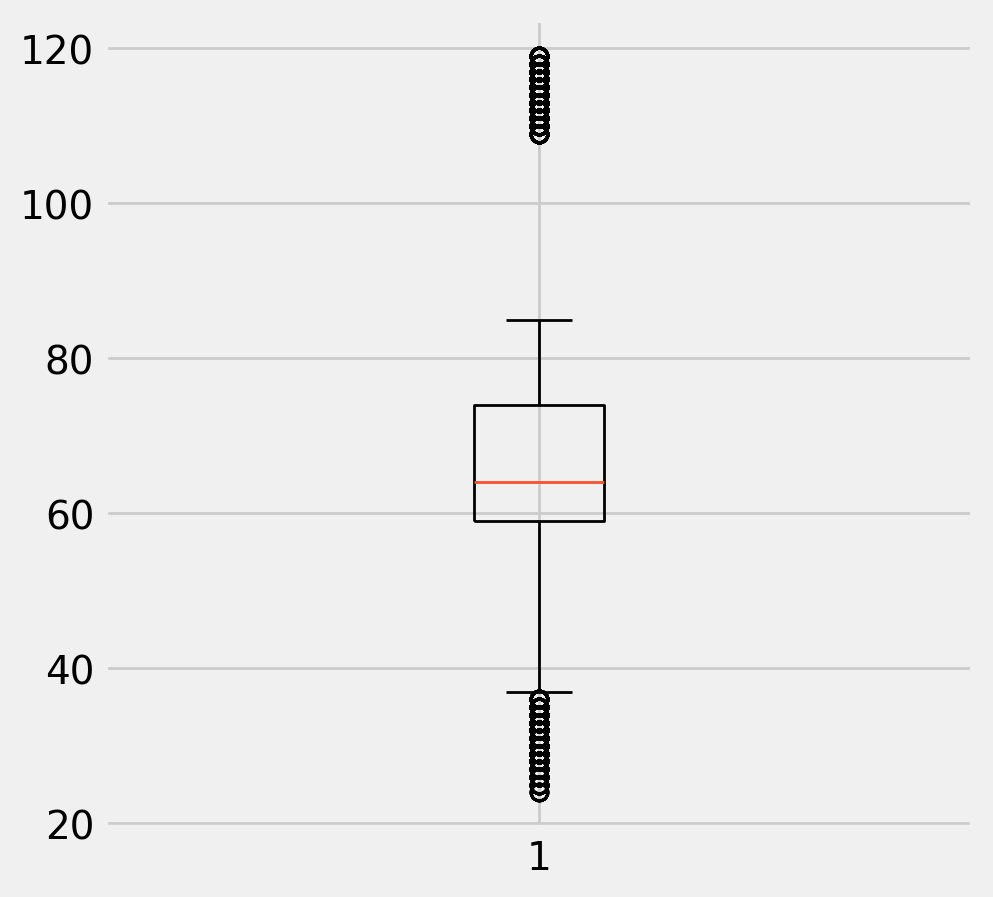

In [ ]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.pre_clean_len)
plt.show()

## Balanceo de etiquetas

In [ ]:
data.describe()

,adults,children,days,pre_clean_len
count,194828.000000,194828.000000,194828.000000,194828.000000
mean,7.292119,2.670058,12.020141,66.514772
std,4.158614,3.126618,9.992767,12.306564
min,0.000000,0.000000,0.000000,24.000000
25%,4.000000,0.000000,1.000000,59.000000
50%,7.000000,1.000000,11.000000,64.000000
75%,11.000000,5.000000,21.000000,74.000000
max,14.000000,9.000000,30.000000,119.000000


In [ ]:
non_zero_counts = data.apply(lambda col: (col != 0).sum())
print('Distribución de etiquetas%')
print(round(non_zero_counts/len(data)*100))

Distribución de etiquetas%
label_NER        100.0
text             100.0
adults            97.0
children          53.0
days              78.0
month             84.0
special_date      13.0
pre_clean_len    100.0
dtype: float64


Clases desbalanceadas:

Es necesario crear mas registros que contengan la etiqueta special_date para poder extraerla correctamente. Para ello se duplican registros para poder aumentar el número de valores !=0. Como la siguiente etiqueta que tiene menor número de registros informados es Children, se deja la condición de que los registros duplicados puedan tener, o no, tambien esta etiqueta:

In [ ]:
# Selecciona los registros a duplicar: special_date &/or children
minority_class=data[(data['special_date'] != 0)
                    & (data['adults'] == 0)
                    & (data['days'] == 0)
                    & (data['month'] == 0)]

# Calcular el número de duplicados necesarios para equilibrar las clases
majority_class_count = round(data['special_date'].value_counts().max()/3)
minority_class_count = len(minority_class)
duplicates_needed = majority_class_count - minority_class_count

# Crear duplicados aleatorios de la clase minoritaria
random_indices = np.random.choice(minority_class.index, size=duplicates_needed, replace=True)
duplicates = data.loc[random_indices]

data = pd.concat([data, duplicates])


In [ ]:
non_zero_counts = data.apply(lambda col: (col != 0).sum())
print('Distribución de etiquetas%')
print(round(non_zero_counts/len(data)*100))

Distribución de etiquetas%
label_NER        100.0
text             100.0
adults            76.0
children          60.0
days              61.0
month             65.0
special_date      32.0
pre_clean_len    100.0
dtype: float64


In [ ]:
print(f'tamaño final de set de entrenamiento: {len(data)}')

tamaño final de set de entrenamiento: 249480


Sigue habiendo demasiada presencia de valores nulos en special_date, pero mantenemos las proporciones ya que el resto se han balanceado muy bien      

# limpieza y preparación

## Preprocesado de texto

In [ ]:
# Define tus stopwords y patrones de limpieza
stop_words = set(stopwords.words('english') + ['...', '#'])
punctuation_translator = str.maketrans('', '', string.punctuation)

num_to_word = {
    0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four',
    5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine',
    10: 'ten', 11: 'eleven', 12: 'twelve', 13: 'thirteen',
    14: 'fourteen', 15: 'fifteen', 16: 'sixteen', 17: 'seventeen',
    18: 'eighteen', 19: 'nineteen', 20: 'twenty', 21: 'twenty-one',
    22: 'twenty-two', 23: 'twenty-three', 24: 'twenty-four',
    25: 'twenty-five', 26: 'twenty-six', 27: 'twenty-seven',
    28: 'twenty-eight', 29: 'twenty-nine', 30: 'thirty'
}

def number_to_words(match):
    num = int(match.group())
    return num_to_word.get(num, str(num))

def clean_and_preprocess_text(text, lemas=False):
    # Aplicar la tokenización y limpieza básica
    text = text.lower().translate(punctuation_translator)

    # Convertir números a palabras
    text = re.sub(r'\b\d+\b', number_to_words, text)

    # Aplicar tokenización con spaCy y lematización si es necesario
    tokens = nlp(text)
    tokens = [tok.lemma_ if lemas else tok.text for tok in tokens if not tok.is_punct and not tok.is_space and tok.text not in stop_words]

    # Filtrar tokens cortos o innecesarios
    cleaned_tokens = [tok for tok in tokens if len(tok) > 2]

    return ' '.join(cleaned_tokens)


In [ ]:
# Limpieza para eliminar partes innecesarias para las redes
data["text_clean"]=[clean_and_preprocess_text(x,lemas=True) for x in  data['text']]

# Limpieza para adaptar el texto a las etiquetas de transformer
data['text_transf']=[x.replace('.','').translate(punctuation_translator).lower()  for x in data['text']]

## Encoding de etiquetas


### Etiquetas para Red neuronal

In [139]:
label_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9,
                 'October': 10, 'November': 11, 'December': 12,
                 'summer': 13, 'Christmas': 14, 'Boxing Day': 15, 'New Year': 16, 'Halloween': 17, 'Valentine': 18}

labels=[ 'adults', 'children', 'days', 'month', 'special_date']

for col_tomap in labels:

    if col_tomap not in ('adults','children', 'days'):
        data[col_tomap]=data[col_tomap].map(label_mapping).fillna(0)

### Etiquetas para Transformer

In [140]:
def encode_labels(labels):
    label_map = {
        'O': 0,
        'B-ADULTS': 1,
        'B-CHILDREN': 2,
        'B-MONTH': 3,
        'B-DAYS':4,
        'B-SPECIAL_DATE': 5
    }
    return [label_map[label] for label in labels.split()]


# Codificar etiquetas
data['encoded_labels'] = data['label_NER'].apply(encode_labels)

In [34]:
print(f'longitud final del dataset de entrenamiento: {len(data)}')

longitud final del dataset de entrenamiento: 249480


# Modelado

## Separación train-validacion-test

Se realizan las particiones teniendo en cuenta todos los datos necesarios para el uso de redes y modelos transformer para poder comparar los resultados obtenidos sobre los mismos conjuntos de datos

In [16]:
x_data=data[['text_clean','text_transf']]
y_data=data[labels+['encoded_labels']]

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42)

In [18]:
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_validation.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

Tamaño del conjunto de entrenamiento: 174636
Tamaño del conjunto de validación: 49898
Tamaño del conjunto de prueba: 24946


## Redes neuronales

### Preparado de datos

In [ ]:
X_train_red=X_train['text_clean']
y_train_red=y_train[labels].values*1


X_test_red=X_test['text_clean']
y_test_red=y_test[labels].values*1


X_val_red=X_validation['text_clean']
y_val_red=y_validation[labels].values*1

In [ ]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(X_train_red)
word_index = tokenizer.word_index
max_features = len(word_index)+1


In [ ]:
def preparado_red(df, max_len=False):
    df = tokenizer.texts_to_sequences(df)
    if max_len:
        df = pad_sequences(df, padding='post', maxlen=max_len)
    else:
        df = pad_sequences(df, padding='post')

    return df

In [ ]:
X_train_red = preparado_red(X_train_red.values)

MAX_SEQUENCE_LENGTH = X_train_red.shape[1]

X_test_red = preparado_red(X_test_red.values,max_len=MAX_SEQUENCE_LENGTH)
X_val_red = preparado_red(X_val_red.values,max_len=MAX_SEQUENCE_LENGTH)

print(f'Número de tokens distintos: {len(word_index)}')

Número de tokens distintos: 85


### Modelado de Redes Neuronales

In [ ]:
def plot_train_performance(history):
    sns.set(style="whitegrid")  # Establece un estilo con una cuadrícula ligera
    plt.figure(figsize=(12, 5))  # Ajusta el tamaño de la figura

    # Primer gráfico (loss)
    plt.subplot(1, 3, 1)  # 1 fila, 2 columnas, primer gráfico
    plt.plot(history.history['loss'], label='Train', linestyle='-')
    plt.plot(history.history['val_loss'], label='Val', linestyle='-')
    plt.title('loss', fontsize=14)
    plt.ylabel('loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True)  # Añade una cuadrícula

    plt.subplot(1, 3, 2)  #
    plt.plot(history.history['mean_absolute_error'], label='Train', linestyle='-')
    plt.plot(history.history['val_mean_absolute_error'], label='Val', linestyle='-')
    plt.title('WE propios - MAE', fontsize=14)
    plt.ylabel('Mean Absolute Error', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True)  # Añade una cuadrícula

    plt.subplot(1, 3, 3)
    plt.plot(history.history['mean_squared_error'], label='Train', linestyle='-')
    plt.plot(history.history['val_mean_squared_error'], label='Val', linestyle='-')
    plt.title('WE propios - MSE', fontsize=14)
    plt.ylabel('Mean Squared Error', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True)  # Añade una cuadrícula

    plt.tight_layout()  #
    plt.show()


#### CNN

In [ ]:
#Parámetros de la red
embed_dim = 50
filters = 64
kernel_size = 3

model1 = Sequential()
model1.add(Embedding(max_features, embed_dim, input_length=MAX_SEQUENCE_LENGTH))
model1.add(Dropout(0.2))

model1.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model1.add(GlobalMaxPooling1D())
model1.add(Dropout(0.3))

model1.add(Dense(64))
model1.add(Dense(5, activation='linear'))

model1.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[MeanAbsoluteError(), MeanSquaredError()])

print(model1.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 50)            4300      
                                                                 
 dropout (Dropout)           (None, 17, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 15, 64)            9664      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=3, restore_best_weights=True)
batch_size=30
history = model1.fit(X_train_red, y_train_red, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_val_red, y_val_red), callbacks=[early_stopping])

Epoch 1/20
5822/5822 - 12s - loss: 3.6943 - mean_absolute_error: 1.1828 - mean_squared_error: 3.6943 - val_loss: 0.3233 - val_mean_absolute_error: 0.4357 - val_mean_squared_error: 0.3233 - 12s/epoch - 2ms/step
Epoch 2/20
5822/5822 - 12s - loss: 2.2835 - mean_absolute_error: 0.9889 - mean_squared_error: 2.2835 - val_loss: 0.3360 - val_mean_absolute_error: 0.4484 - val_mean_squared_error: 0.3360 - 12s/epoch - 2ms/step
Epoch 3/20
5822/5822 - 12s - loss: 2.2275 - mean_absolute_error: 0.9777 - mean_squared_error: 2.2275 - val_loss: 0.3906 - val_mean_absolute_error: 0.4754 - val_mean_squared_error: 0.3906 - 12s/epoch - 2ms/step
Epoch 4/20
5822/5822 - 12s - loss: 2.1852 - mean_absolute_error: 0.9680 - mean_squared_error: 2.1852 - val_loss: 0.2903 - val_mean_absolute_error: 0.4065 - val_mean_squared_error: 0.2903 - 12s/epoch - 2ms/step
Epoch 5/20
5822/5822 - 12s - loss: 2.1572 - mean_absolute_error: 0.9618 - mean_squared_error: 2.1572 - val_loss: 0.4741 - val_mean_absolute_error: 0.5088 - val_

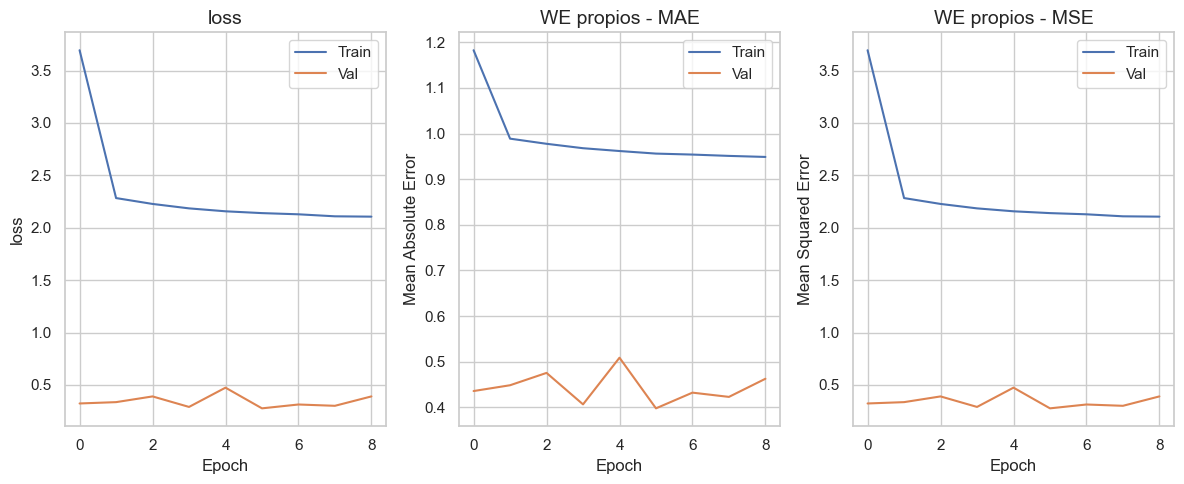

In [ ]:
plot_train_performance(history)

In [ ]:
model1.evaluate(X_test_red, y_test_red)

780/780 [==============================] - 1s 981us/step - loss: 0.2746 - mean_absolute_error: 0.3963 - mean_squared_error: 0.2746


[0.2746005952358246, 0.39630842208862305, 0.2746005952358246]

#### CRNN

In [ ]:
# Relu porque es o 0 o positiva

In [ ]:
# Parámetros de la red
embed_dim = 50
filters = 64
kernel_size = 3

model2 = Sequential()
model2.add(Embedding(max_features, embed_dim, input_length=MAX_SEQUENCE_LENGTH))
model2.add(LSTM(64, return_sequences=True))
model2.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.5))  # Aumento de la tasa de dropout
model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # Regularización L2
model2.add(Dense(5, activation='linear', kernel_regularizer=l2(0.001)))  # Regularización L2

# Compilación del modelo con tasa de aprendizaje reducida
optimizer = Adam(learning_rate=0.0001)  # Tasa de aprendizaje reducida
model2.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[MeanAbsoluteError(), MeanSquaredError()])
print(model2.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 17, 50)            4300      
                                                                 
 lstm_3 (LSTM)               (None, 17, 64)            29440     
                                                                 
 conv1d_4 (Conv1D)           (None, 15, 64)            12352     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=3, restore_best_weights=True)
batch_size=30
history = model2.fit(X_train_red, y_train_red, epochs=50, batch_size=batch_size, verbose=2, validation_data=(X_val_red, y_val_red), callbacks=[early_stopping])

Epoch 1/50
5822/5822 - 34s - loss: 18.1944 - mean_absolute_error: 3.0930 - mean_squared_error: 18.1275 - val_loss: 9.2775 - val_mean_absolute_error: 2.1105 - val_mean_squared_error: 9.2085 - 34s/epoch - 6ms/step
Epoch 2/50
5822/5822 - 32s - loss: 9.0100 - mean_absolute_error: 2.1323 - mean_squared_error: 8.9382 - val_loss: 9.5678 - val_mean_absolute_error: 2.1491 - val_mean_squared_error: 9.4931 - 32s/epoch - 5ms/step
Epoch 3/50
5822/5822 - 32s - loss: 6.1096 - mean_absolute_error: 1.7662 - mean_squared_error: 6.0303 - val_loss: 10.0390 - val_mean_absolute_error: 2.0787 - val_mean_squared_error: 9.9556 - 32s/epoch - 5ms/step
Epoch 4/50
5822/5822 - 32s - loss: 4.2004 - mean_absolute_error: 1.4268 - mean_squared_error: 4.1134 - val_loss: 11.3844 - val_mean_absolute_error: 2.0434 - val_mean_squared_error: 11.2941 - 32s/epoch - 5ms/step


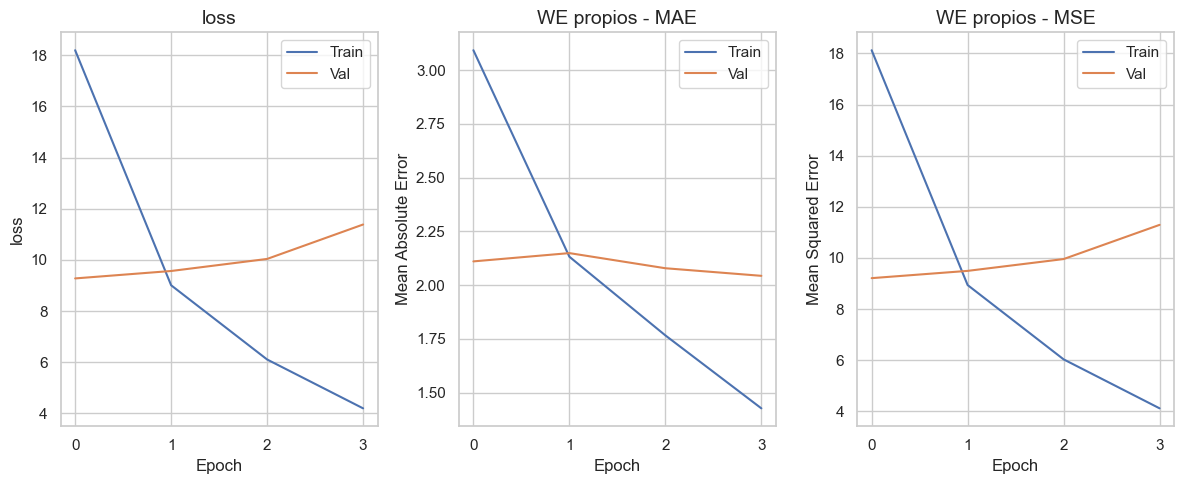

In [ ]:
plot_train_performance(history)

In [ ]:
model2.evaluate(X_test_red, y_test_red)

780/780 [==============================] - 2s 2ms/step - loss: 9.3114 - mean_absolute_error: 2.1150 - mean_squared_error: 9.2425


[9.311434745788574, 2.1150147914886475, 9.242496490478516]

Empeora el rendimiento, existencia de sobreajuste

#### CRNN + embeddings GloVe

In [ ]:
EMBEDDING_DIM = nlp.vocab.vectors_length
embedding_matrix_glove = np.zeros((max_features, EMBEDDING_DIM))
n = 0
for word, i in word_index.items():
    if (i >= max_features):
        break
    if nlp.vocab[word].has_vector:
        embedding_matrix_glove[i] = nlp.vocab[word].vector
        n += 1
print(f"Cargados {n} vectores en la matriz")


Cargados 83 vectores en la matriz


In [ ]:
# Crear el modelo
model3 = Sequential()
model3.add(Embedding(max_features, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix_glove], trainable=False))
model3.add(LSTM(64, return_sequences=True))
model3.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.5))
model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model3.add(Dense(5, activation='linear', kernel_regularizer=l2(0.001)))

# Compilación del modelo con tasa de aprendizaje reducida
optimizer = Adam(learning_rate=0.0001)  # Tasa de aprendizaje reducida
model3.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[MeanAbsoluteError(), MeanSquaredError()])
print(model3.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 50)            4300      
                                                                 
 dropout (Dropout)           (None, 17, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 15, 64)            9664      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=3, restore_best_weights=True)
batch_size=30
history = model3.fit(X_train_red, y_train_red, epochs=50, batch_size=batch_size, verbose=2, validation_data=(X_val_red, y_val_red), callbacks=[early_stopping])

Epoch 1/50
5822/5822 - 47s - loss: 8.7596 - mean_absolute_error: 1.9914 - mean_squared_error: 8.6818 - val_loss: 1.4881 - val_mean_absolute_error: 0.8780 - val_mean_squared_error: 1.4078 - 47s/epoch - 8ms/step
Epoch 2/50
5822/5822 - 46s - loss: 3.3428 - mean_absolute_error: 1.2317 - mean_squared_error: 3.2598 - val_loss: 3.1772 - val_mean_absolute_error: 1.1672 - val_mean_squared_error: 3.0913 - 46s/epoch - 8ms/step
Epoch 3/50
5822/5822 - 47s - loss: 2.4092 - mean_absolute_error: 1.0448 - mean_squared_error: 2.3208 - val_loss: 6.0311 - val_mean_absolute_error: 1.4945 - val_mean_squared_error: 5.9406 - 47s/epoch - 8ms/step
Epoch 4/50
5822/5822 - 48s - loss: 1.8105 - mean_absolute_error: 0.8976 - mean_squared_error: 1.7184 - val_loss: 8.9261 - val_mean_absolute_error: 1.7884 - val_mean_squared_error: 8.8327 - 48s/epoch - 8ms/step


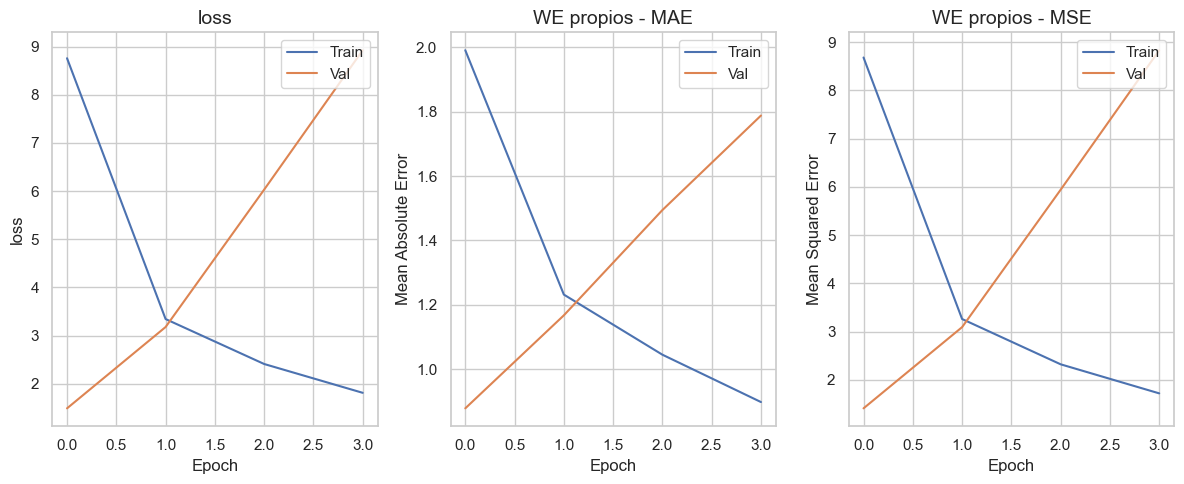

In [ ]:
plot_train_performance(history)

In [ ]:
model3.evaluate(X_test_red, y_test_red)

780/780 [==============================] - 3s 4ms/step - loss: 1.4791 - mean_absolute_error: 0.8747 - mean_squared_error: 1.3988


[1.4791349172592163, 0.8746968507766724, 1.3988076448440552]

Mejora el rendimiento, pero sigue habiendo un claro Sobreajuste

#### CRNN + CV

In [ ]:
x_data_process = tokenizer.texts_to_sequences(x_data['text_clean'].values)
x_data_process = pad_sequences(x_data_process, padding='post')
y_data_process=y_data[labels].values*1

In [ ]:
# Crear un generador de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lista para almacenar los resultados de validación
val_losses = []
val_maes = []
val_mses = []

# Entrenamiento y validación para cada división de datos
for train_index, val_index in kf.split(x_data_process):  # Usando X_train
    X_train_split, X_val = x_data_process[train_index], x_data_process[val_index]  # Usando X_train
    y_train_split, y_val = y_data_process[train_index], y_data_process[val_index]

    # Crear el modelo
    model4 = Sequential()
    model4.add(Dense(64, input_dim=X_train_split.shape[1], activation='relu'))
    model4.add(Dense(5, activation='linear', kernel_regularizer=l2(0.001)))

    # Compilar el modelo
    optimizer = Adam(learning_rate=0.0001)
    model4.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[MeanAbsoluteError(), MeanSquaredError()])

    early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=3, restore_best_weights=True)

    # Entrenar el modelo
    history = model4.fit(X_train_split, y_train_split, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0,callbacks=[early_stopping])

    # Evaluar en el conjunto de validación actual
    val_loss, val_mae, val_mse = model4.evaluate(X_val, y_val)
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    val_mses.append(val_mse)

# Calcular promedios de métricas de validación cruzada
avg_val_loss = sum(val_losses) / len(val_losses)
avg_val_mae = sum(val_maes) / len(val_maes)
avg_val_mse = sum(val_mses) / len(val_mses)

# Imprimir resultados
print(f"Promedio de pérdida en validación cruzada: {avg_val_loss}")
print(f"Promedio de MAE en validación cruzada: {avg_val_mae}")
print(f"Promedio de MSE en validación cruzada: {avg_val_mse}")


1560/1560 [==============================] - 1s 825us/step - loss: 9.3678 - mean_absolute_error: 2.1824 - mean_squared_error: 9.3155
Promedio de pérdida en validación cruzada: 9.453998947143555
Promedio de MAE en validación cruzada: 2.167987251281738
Promedio de MSE en validación cruzada: 9.404335975646973


#### CRNN (2LSTM) + CV

1560/1560 [==============================] - 6s 4ms/step - loss: 0.1619 - mean_absolute_error: 0.2918 - mean_squared_error: 0.1505
Promedio de pérdida en validación cruzada: 0.20259955525398254
Promedio de MAE en validación cruzada: 0.32174049615859984
Promedio de MSE en validación cruzada: 0.18990829586982727


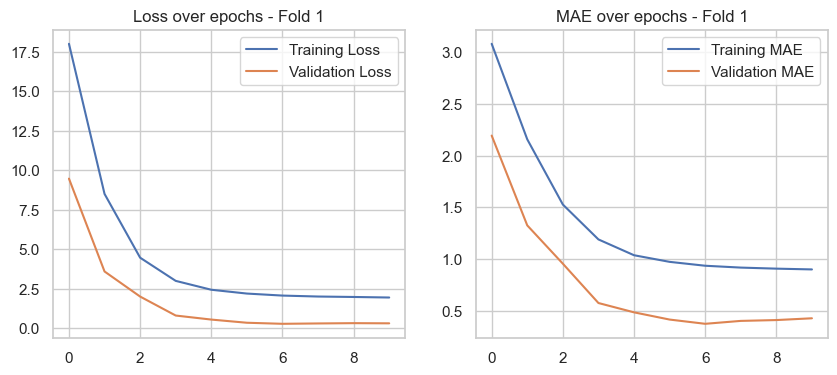

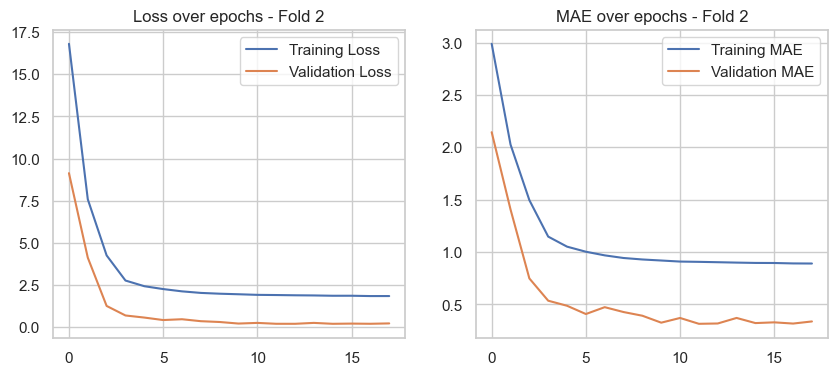

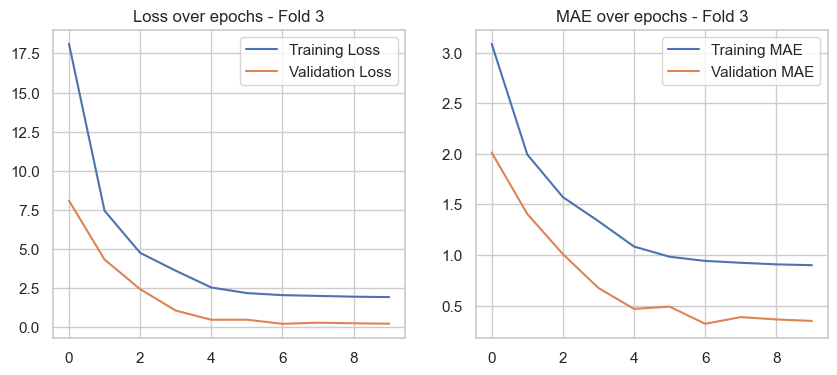

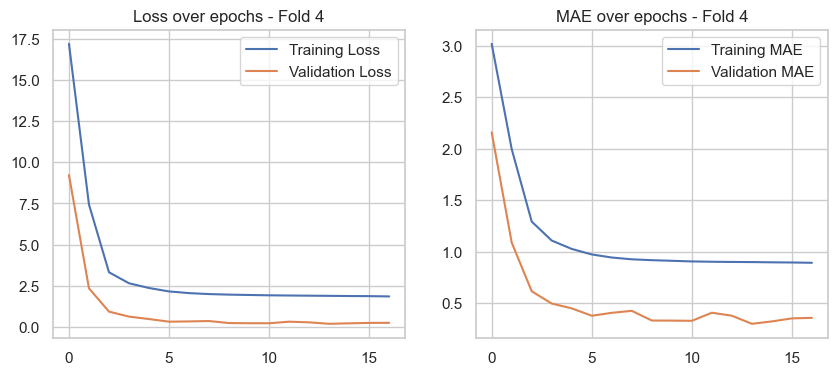

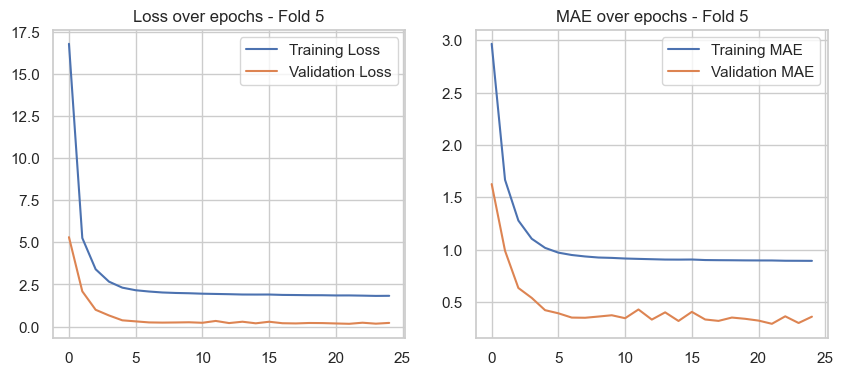

In [ ]:
embed_dim = 50
filters = 64
kernel_size = 3
# Crear un generador de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lista para almacenar los resultados de validación
val_losses = []
val_maes = []
val_mses = []

# Lista para almacenar historias de entrenamiento
all_histories = []

# Entrenamiento y validación para cada división de datos
for train_index, val_index in kf.split(x_data_process):  # Usando x_data_process
    X_train_split, X_val = x_data_process[train_index], x_data_process[val_index]  # Usando x_data_process
    y_train_split, y_val = y_data_process[train_index], y_data_process[val_index]

    # Crear el modelo
    model5 = Sequential()
    model5.add(Embedding(input_dim=max_features, output_dim=embed_dim, input_length=X_train_split.shape[1]))
    model5.add(LSTM(64, return_sequences=True))
    model5.add(LSTM(64))
    model5.add(Dense(64, activation='relu'))
    model5.add(Dropout(0.3))
    model5.add(Dense(5, activation='linear', kernel_regularizer=l2(0.001)))

    # Compilar el modelo
    optimizer = Adam(learning_rate=0.0001)
    model5.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[MeanAbsoluteError(), MeanSquaredError()])

    # Entrenar el modelo
    early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=3, restore_best_weights=True)

    # Entrenar el modelo
    history = model5.fit(X_train_split, y_train_split, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0,callbacks=[early_stopping])
    all_histories.append(history)

    # Evaluar en el conjunto de validación actual
    val_loss, val_mae, val_mse = model5.evaluate(X_val, y_val)
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    val_mses.append(val_mse)

# Calcular promedios de métricas de validación cruzada
avg_val_loss = sum(val_losses) / len(val_losses)
avg_val_mae = sum(val_maes) / len(val_maes)
avg_val_mse = sum(val_mses) / len(val_mses)

# Imprimir resultados
print(f"Promedio de pérdida en validación cruzada: {avg_val_loss}")
print(f"Promedio de MAE en validación cruzada: {avg_val_mae}")
print(f"Promedio de MSE en validación cruzada: {avg_val_mse}")

# Gráficos de desempeño
for i, history in enumerate(all_histories):
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'Loss over epochs - Fold {i+1}')

    plt.subplot(1,2,2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.legend()
    plt.title(f'MAE over epochs - Fold {i+1}')

    plt.show()


In [ ]:
final_model = Sequential()
final_model.add(Embedding(input_dim=max_features, output_dim=embed_dim, input_length=x_data_process.shape[1]))
final_model.add(LSTM(64, return_sequences=True))
final_model.add(LSTM(64))
final_model.add(Dense(64, activation='relu'))
final_model.add(Dropout(0.3))
final_model.add(Dense(5, activation='linear', kernel_regularizer=l2(0.001)))

# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
final_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[MeanAbsoluteError(), MeanSquaredError()])

# Configurar detención temprana
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo en todo el conjunto de datos
history_final = final_model.fit(X_train_red, y_train_red, epochs=50, batch_size=batch_size, validation_data=(X_val_red, y_val_red),  verbose=0, callbacks=[early_stopping])

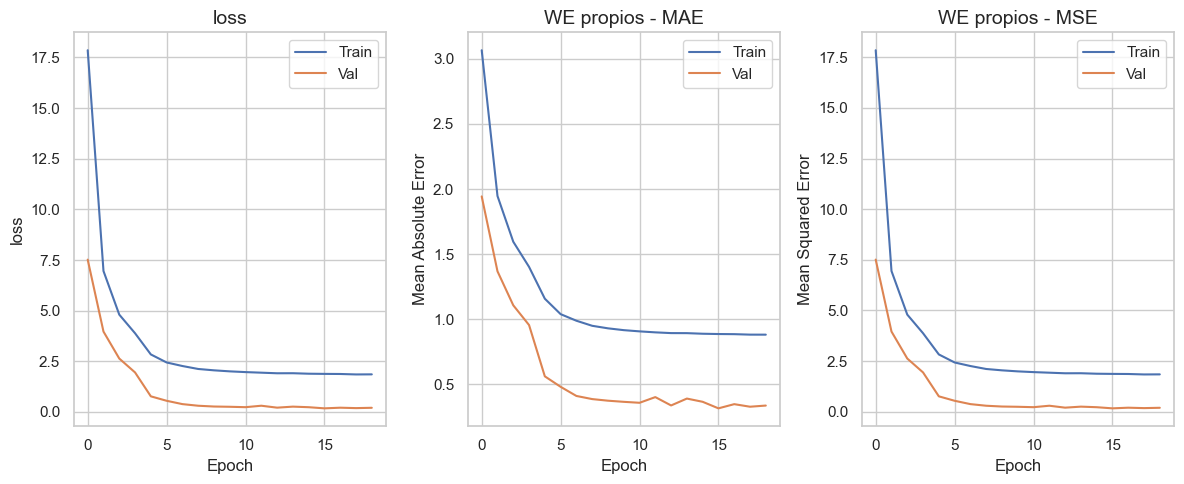

In [ ]:
plot_train_performance(history_final)

In [ ]:
final_model.evaluate(X_test_red, y_test_red)


780/780 [==============================] - 3s 4ms/step - loss: 0.1798 - mean_absolute_error: 0.3157 - mean_squared_error: 0.1674


[0.17984098196029663, 0.31572991609573364, 0.16742368042469025]

Ya no hay sobre ajuste y ofrece las mejores métricas

### Selección mejor red:  CRNN (2LSTM)


Se recostruye de nuevo la estructura y se entrena con todos los datos

In [ ]:
final_model = Sequential()
final_model.add(Embedding(input_dim=max_features, output_dim=embed_dim, input_length=x_data_process.shape[1]))
final_model.add(LSTM(64, return_sequences=True))
final_model.add(LSTM(64))
final_model.add(Dense(64, activation='relu'))
final_model.add(Dropout(0.3))
final_model.add(Dense(5, activation='linear', kernel_regularizer=l2(0.001)))

# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
final_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[MeanAbsoluteError(), MeanSquaredError()])

# Configurar detención temprana
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo en todo el conjunto de datos
history_final = final_model.fit(x_data_process, y_data_process, epochs=50, batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[early_stopping])  # Asumiendo un split de validación del 10%

In [ ]:
print(final_model.summary())


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 17, 50)            4300      
                                                                 
 lstm_17 (LSTM)              (None, 17, 64)            29440     
                                                                 
 lstm_18 (LSTM)              (None, 64)                33024     
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 5)                 325       
                                                                 
Total params: 71249 (278.32 KB)
Trainable params: 712

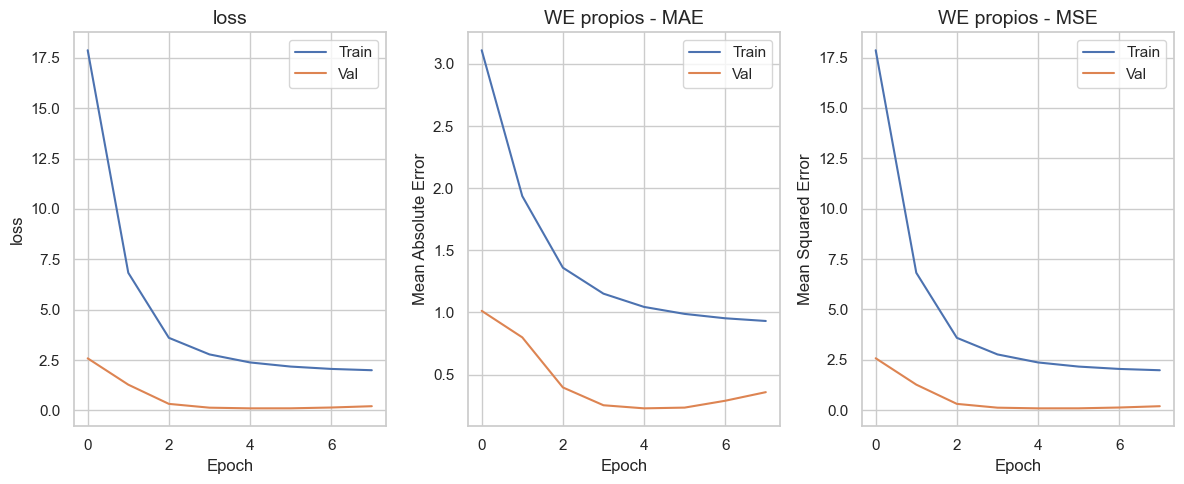

In [ ]:
plot_train_performance(history_final)

A partir de la época 5 sobreajusta un poco

In [ ]:
final_model.save('final_neuronal_net.h5')


## Modelos Transformer

Se va a realizar un proceso de fine tunning del modelo BERT NER, preentrenado para la extracción de entidades

In [10]:
model_type='dslim/bert-base-NER'


### Preparado de datos

Debido a que la tokenización del modelo altera el tamaño de los textos partiendo algunas palabras por la mitad etc, es necesario adaptar la etiqueta asociada al nuevo tamaño tras tokenizar.

In [19]:
train_bert=pd.concat([x_data['text_transf'],y_data['encoded_labels']],axis=1)

test_bert=pd.concat([X_test['text_transf'],y_test['encoded_labels']],axis=1)

val_bert=pd.concat([X_validation['text_transf'],y_validation['encoded_labels']],axis=1)

In [20]:
tokenizer = BertTokenizerFast.from_pretrained(model_type)

In [21]:
def tokenize_and_align_labels(text, labels, tokenizer):
    # mapeo de etiquetas con ubicación en el texto
    words = text.split(' ')
    mapping_dict = {}
    start_index = 0

    for w, tag in zip(words, labels):
        start_index = text.find(w, start_index)
        mapping_dict[start_index] = tag
        start_index += len(w)


    # tokenizado de texto para modelo transformer
    tokenized_input = tokenizer(text, return_offsets_mapping=True, padding='max_length', truncation=True, max_length=128)
    tokens = tokenized_input['input_ids']
    offset_mapping = tokenized_input['offset_mapping']

    # adaptación de la lista de etiquetas tras el tokenizado (las posiciones cambian)
    tokenized_labels = [0] * len(tokenized_input["input_ids"])

    # Recorre los tokens tokenizados y sus offsets
    for i, (start_offset, end_offset) in enumerate(tokenized_input["offset_mapping"]):
        if i>0:
            # Encuentra las etiquetas originales en el rango de offsets
            tokenized_labels[i]  = mapping_dict.get(start_offset,0)

    assert len(tokenized_input["input_ids"])== len(tokenized_labels)
    return tokenized_input,tokenized_labels

In [22]:
train_bert = train_bert.apply(lambda row: tokenize_and_align_labels(row['text_transf'], row['encoded_labels'],tokenizer), axis=1)
test_bert = test_bert.apply(lambda row: tokenize_and_align_labels(row['text_transf'], row['encoded_labels'],tokenizer), axis=1)
val_bert = val_bert.apply(lambda row: tokenize_and_align_labels(row['text_transf'], row['encoded_labels'],tokenizer), axis=1)

In [23]:
# Extraer inputs y etiquetas
train_inputs = [item[0] for item in train_bert]
train_labels = [item[1] for item in train_bert]

val_inputs = [item[0] for item in val_bert]
val_labels = [item[1] for item in val_bert]

test_inputs = [item[0] for item in test_bert]
test_labels = [item[1] for item in test_bert]


In [24]:
# Convertir datos a tensores
train_inputs = {
    "input_ids": tf.convert_to_tensor([entry["input_ids"] for entry in train_inputs]),
    "attention_mask": tf.convert_to_tensor([entry["attention_mask"] for entry in train_inputs])}
train_labels = tf.convert_to_tensor(train_labels)

val_inputs = {
    "input_ids": tf.convert_to_tensor([entry["input_ids"] for entry in val_inputs]),
    "attention_mask": tf.convert_to_tensor([entry["attention_mask"] for entry in val_inputs])}
val_labels = tf.convert_to_tensor(val_labels)

test_inputs = {
    "input_ids": tf.convert_to_tensor([entry["input_ids"] for entry in test_inputs]),
    "attention_mask": tf.convert_to_tensor([entry["attention_mask"] for entry in test_inputs])}
test_labels = tf.convert_to_tensor(test_labels)



### fine-tuning Transformer

In [ ]:
model_bert = TFBertForTokenClassification.from_pretrained(model_type)


In [26]:
model_bert.classifier = tf.keras.layers.Dense(6, name='classifier') #6 etiquetas: 5 entidades + entidad vacía

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_bert.compile(optimizer=optimizer, loss=loss, metrics=[metric])
print(model_bert.summary())

Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  107719680 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  0 (unused)
                                                                 
Total params: 107719680 (410.92 MB)
Trainable params: 107719680 (410.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [28]:
# Entrenar el modelo

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history=model_bert.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels),
                       epochs=3,
                       batch_size=30,
                       callbacks=[early_stopping]

                      )

Epoch 1/3
8316/8316 [==============================] - 6375s 767ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 1.3384e-08 - val_accuracy: 1.0000
Epoch 2/3
8316/8316 [==============================] - 6380s 767ms/step - loss: 3.0180e-06 - accuracy: 1.0000 - val_loss: 9.4363e-10 - val_accuracy: 1.0000
Epoch 3/3
8316/8316 [==============================] - 6372s 766ms/step - loss: 2.5821e-06 - accuracy: 1.0000 - val_loss: 7.8861e-10 - val_accuracy: 1.0000


Código interrumpido manualmente por alcanzar las métricas deseadas

In [39]:
model_bert.save_pretrained('../Models/final_model')


### Evaluación modelo Transformer

In [30]:
model_bert.evaluate(test_inputs, test_labels)


780/780 [==============================] - 207s 265ms/step - loss: 7.6549e-10 - accuracy: 1.0000


[7.654868405815307e-10, 1.0]

In [31]:
id2label ={
    0: 'O',
    1: 'B-ADULTS',
    2: 'B-CHILDREN',
    3: 'B-MONTH',
    4: 'B-DAYS',
    5: 'B-SPECIAL_DATE'
}

In [35]:
prediction=model_bert.predict(test_inputs)

logits = prediction.logits if hasattr(prediction, 'logits') else prediction['logits']

probs = softmax(logits, axis=-1)

predictions = np.argmax(probs, axis=-1)

780/780 [==============================] - 207s 265ms/step


In [36]:
etiquetas_reales = test_labels.numpy()

etiquetas_reales_texto = [[id2label[etiqueta] for etiqueta in secuencia] for secuencia in etiquetas_reales]
predictions_texto = [[id2label[etiqueta] for etiqueta in secuencia] for secuencia in predictions]


In [37]:
reporte = classification_report(etiquetas_reales_texto, predictions_texto)


In [38]:
print("Reporte de Clasificación:\n", reporte)


Reporte de Clasificación:
               precision    recall  f1-score   support

      ADULTS       1.00      1.00      1.00     19480
    CHILDREN       1.00      1.00      1.00     15106
        DAYS       1.00      1.00      1.00     15612
       MONTH       1.00      1.00      1.00     16303
SPECIAL_DATE       1.00      1.00      1.00      8071

   micro avg       1.00      1.00      1.00     74572
   macro avg       1.00      1.00      1.00     74572
weighted avg       1.00      1.00      1.00     74572



El rendimiento del modelo transformer se ajusta a la perfección a las necesidades del proyecto dadas las entradas sintéticas generadas previamente